## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, pairwise_distances, pairwise_kernels
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
import re
import html
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras import models, layers, optimizers, losses, regularizers, metrics
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks
from keras.utils import to_categorical
from keras.layers import Dropout



nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HasEAhmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HasEAhmed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HasEAhmed\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HasEAhmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## functions

In [2]:
def performance_results(model,features,y_actual):
    # Predict on the dataset
    y_pred = model.predict(features)

    # Convert the predicted values to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert the encoded labels back to their original categories
    y_original = label_encoder.inverse_transform(y_actual)

    # Convert the predicted class labels back to their original categories
    y_pred_original = label_encoder.inverse_transform(y_pred_classes)

    # Calculate accuracy
    accuracy = np.mean(y_original == y_pred_original)
    
    report = classification_report(y_original, y_pred_original)

    return y_pred_original,y_original,accuracy,report

In [3]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    
    return ' '.join(words)

def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

## Data Perperation

In [4]:
# Load the dataset
df = pd.read_csv('../data/Dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# Filter rows where 'stockcode' is not entirely characters
df = df[~df['StockCode'].str.isalpha()]

In [8]:
df['StockCode'] = df['StockCode'].apply(str.lower)

In [9]:
df = df[df['Quantity'] > 0]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529083 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    529083 non-null  object        
 1   StockCode    529083 non-null  object        
 2   Description  528496 non-null  object        
 3   Quantity     529083 non-null  int64         
 4   InvoiceDate  529083 non-null  datetime64[ns]
 5   UnitPrice    529083 non-null  float64       
 6   CustomerID   396515 non-null  float64       
 7   Country      529083 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.3+ MB


In [11]:
df = df.drop_duplicates()

In [12]:
null_percentage = df.isnull().mean() * 100

In [13]:
null_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.112053
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.298698
Country         0.000000
dtype: float64

In [14]:
def replace_nulls(group):
    value_counts = group.value_counts()
    if len(value_counts) > 0:
        return group.fillna(value_counts.idxmax())
    else:
        return group

df['CustomerID'] = df.groupby('CustomerID')['CustomerID'].transform(replace_nulls)

In [15]:
null_percentage = df.isnull().mean() * 100

In [16]:
null_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.112053
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.298698
Country         0.000000
dtype: float64

In [17]:
df = df.dropna(subset=['CustomerID'])

In [18]:
null_percentage = df.isnull().mean() * 100

In [19]:
null_percentage

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391328 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    391328 non-null  object        
 1   StockCode    391328 non-null  object        
 2   Description  391328 non-null  object        
 3   Quantity     391328 non-null  int64         
 4   InvoiceDate  391328 non-null  datetime64[ns]
 5   UnitPrice    391328 non-null  float64       
 6   CustomerID   391328 non-null  float64       
 7   Country      391328 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 26.9+ MB


In [21]:
df.to_csv('../data/preprocessed_data_1.csv')

cleaning summary

In this code, we started by loading a dataset called 'Dataset.csv', which contained important information for our analysis. We began by performing some initial data exploration and preprocessing steps to ensure the quality of the data.

First, we converted the 'InvoiceDate' column to a datetime format to facilitate time-based analysis. We then focused on the 'StockCode' column and filtered out any rows that contained non-alphabetic characters. Additionally, we standardized the 'StockCode' values by converting them to lowercase for consistency.

Next, we addressed issues related to the 'Quantity' column. We removed any rows where the quantity was less than or equal to zero, as negative or zero quantities would not provide meaningful insights for our analysis.

Dealing with missing values was the next crucial step. We examined the dataset for null values and identified columns with missing data. For the 'CustomerID' column, we implemented a strategy to replace the missing values. We created a function, 'replace_nulls', which replaced null values in a group with the most frequent non-null value within that group. By applying this function to the 'CustomerID' column, we were able to fill in the missing values effectively.

After filling the missing values, we conducted a final check to ensure that all null values had been addressed. The dataset was then deemed clean, and we proceeded to save the preprocessed data to a new CSV file named 'preprocessed_data_1.csv'.

after that cleaning we are ready to go to the next step, data splitting and transformation

## Dataset Spliting and Transformation

In [22]:
df_transformed = df.copy()

# Fit and transform the user labels on the train data
user_enc = LabelEncoder()
df_transformed['CustomerID'] = user_enc.fit_transform(df_transformed.CustomerID.values)
n_users = df_transformed['CustomerID'].nunique()

# Fit and transform the item labels on the train data
item_enc = LabelEncoder()
df_transformed['StockCode'] = item_enc.fit_transform(df_transformed.StockCode.values)
n_items = df_transformed['StockCode'].nunique()

# Fit and transform the user labels on the train data
conuntry_enc = LabelEncoder()
df['Country'] = conuntry_enc.fit_transform(df_transformed.Country.values)
n_countries = df_transformed['Country'].nunique()

In [23]:
np.save('../encoder/user_enc_1.npy', user_enc.classes_)
np.save('../encoder/item_enc_1.npy', item_enc.classes_)
np.save('../encoder/conuntry_enc_1.npy', conuntry_enc.classes_)

In [24]:
# Sort the DataFrame by the date column in ascending order
df_transformed = df_transformed.sort_values('InvoiceDate')

# Calculate the cutoff date for the test set
test_cutoff = df_transformed['InvoiceDate'].max() - pd.DateOffset(months=2)

# Split the data into training and testing sets
train = df_transformed[df_transformed['InvoiceDate'] < test_cutoff]
test = df_transformed[df_transformed['InvoiceDate'] >= test_cutoff]

In [25]:
len(train)/(len(train)+len(test))

0.7024593180145555

In [26]:
# Grouping the dataset and calculating desired metrics
train = train.groupby(['StockCode', 'Description', 'CustomerID', 'Country']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'first',
    'InvoiceNo': 'count'
})

# Rename the columns for clarity
train = train.rename(columns={
    'Quantity': 'total_quantity',
    'UnitPrice': 'unit_price',
    'InvoiceNo': 'number_of_orders'
})

# Calculate the total price
train['total_price'] = train['total_quantity'] * train['unit_price']

# Reset the index to make the grouped columns as regular columns
train = train.reset_index()

# Grouping the dataset and calculating desired metrics
test = test.groupby(['StockCode', 'Description', 'CustomerID', 'Country']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'first',
    'InvoiceNo': 'count'
})

# Rename the columns for clarity
test = test.rename(columns={
    'Quantity': 'total_quantity',
    'UnitPrice': 'unit_price',
    'InvoiceNo': 'number_of_orders'
})

# Calculate the total price
test['total_price'] = test['total_quantity'] * test['unit_price']

# Reset the index to make the grouped columns as regular columns
test = test.reset_index()

## Feature Engineering and Modeling

In [27]:
# Define the relevancy categories and their corresponding bins
relevancy_categories = ['Low', 'Medium', 'High']
relevancy_bins = [0, 2, 5, float('inf')]

# Convert the "number of orders" column to the categorical feature
train['relevancy'] = pd.cut(train['number_of_orders'], bins=relevancy_bins, labels=relevancy_categories, right=False)

# Convert the "number of orders" column to the categorical feature
test['relevancy'] = pd.cut(test['number_of_orders'], bins=relevancy_bins, labels=relevancy_categories, right=False)

In [28]:
train['relevancy'].value_counts()

Low       156065
Medium     37528
High        4140
Name: relevancy, dtype: int64

In [896]:
label_column =  'relevancy'

input_columns = ['CustomerID', 'StockCode','total_quantity','total_price']

In [897]:
X_train = train[input_columns].values
y_train = train[label_column].values

X_test = test[input_columns].values
y_test = test[label_column].values

In [898]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on y_train
label_encoder.fit(y_train)

# Transform y_train to model representation
y_train_encoded = label_encoder.transform(y_train)

# Transform y_test to model representation
y_test_encoded = label_encoder.transform(y_test)

In [899]:

# Perform one-hot encoding on y_train_encoded
y_train_encoded_onehot = to_categorical(y_train_encoded)
y_test_encoded_onehot = to_categorical(y_test_encoded)

In [803]:
# Number of latent factors
emb_sz = 32

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1)(user)
user_bias = layers.Reshape((1,))(user_bias)

# item embeddings
item = layers.Input(shape=(1,), name='item_id')
item_emb = layers.Embedding(n_items, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='item_embedding_LUT')(item)
item_emb = layers.Reshape((emb_sz,))(item_emb)

# item bias
item_bias = layers.Embedding(n_items, 1)(item)
item_bias = layers.Reshape((1,))(item_bias)

#other features
total_quantity = Input(shape=(1,))
total_price = Input(shape=(1,))

# Dot product
relevancy = layers.Concatenate()([user_emb, item_emb, total_quantity, total_price, user_bias, item_bias])

# Add biases
relevancy = layers.Dense(100, activation='relu')(relevancy)
relevancy = layers.Dense(3, activation='softmax', name='relevancy')(relevancy)

# Model
model_3 = models.Model(inputs=[user, item, total_quantity, total_price], outputs=relevancy)

In [804]:
# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])

history_3 = model_3.fit(x=[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3]], y=y_train_encoded_onehot,
                    batch_size=64, epochs=20,
                    validation_split=0.2)

Epoch 1/20


c:\Users\HasEAhmed\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2652/2652 [==============================] - 9s 3ms/step - loss: 0.6797 - accuracy: 0.8270 - val_loss: 0.4859 - val_accuracy: 0.8306
Epoch 2/20
2652/2652 [==============================] - 8s 3ms/step - loss: 0.4713 - accuracy: 0.8679 - val_loss: 0.6640 - val_accuracy: 0.8168
Epoch 3/20
2652/2652 [==============================] - 8s 3ms/step - loss: 0.5367 - accuracy: 0.8783 - val_loss: 0.4446 - val_accuracy: 0.8345
Epoch 4/20
2652/2652 [==============================] - 8s 3ms/step - loss: 0.4900 - accuracy: 0.8909 - val_loss: 0.4667 - val_accuracy: 0.8333
Epoch 5/20
2652/2652 [==============================] - 7s 3ms/step - loss: 0.4163 - accuracy: 0.8956 - val_loss: 0.4399 - val_accuracy: 0.8366
Epoch 6/20
2652/2652 [==============================] - 7s 3ms/step - loss: 0.4174 - accuracy: 0.9006 - val_loss: 0.4658 - val_accuracy: 0.8306
Epoch 7/20
2652/2652 [==============================] - 8s 3ms/step - loss: 0.4565 - accuracy: 0.9056 - val_loss: 0.5079 - val_accuracy: 0.8063
Epo

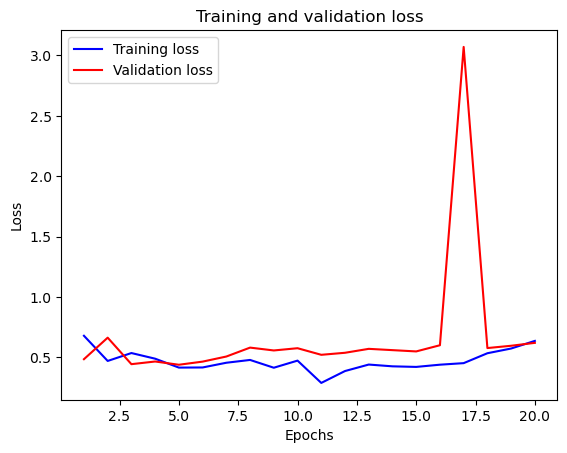

In [805]:
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


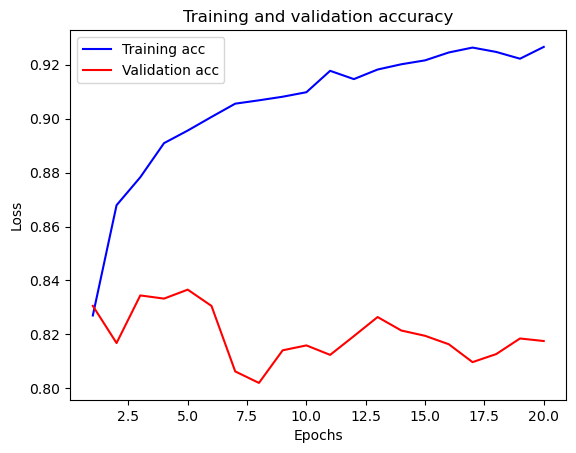

In [806]:

plt.clf()   # clear figure
acc_values = history_3.history['accuracy']
val_acc_values = history_3.history['val_accuracy']

plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [835]:
y_pred_original_train,y_train_original,accuracy,report = performance_results(model_3,[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3]],y_train_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_train)
print("True labels:", y_train_original)
print("Accuracy:", accuracy)
print(report)

6629/6629 [==============================] - 11s 2ms/step
Predicted labels: ['Low' 'Low' 'Medium' ... 'Low' 'Low' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Low' 'Low' 'Low']
Accuracy: 0.9174917491749175
              precision    recall  f1-score   support

        High       0.69      0.78      0.73      4817
         Low       0.95      0.96      0.95    166534
      Medium       0.82      0.75      0.78     40749

    accuracy                           0.92    212100
   macro avg       0.82      0.83      0.82    212100
weighted avg       0.92      0.92      0.92    212100



In [836]:
y_pred_original_test,y_test_original,accuracy,report = performance_results(model_3,[X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3]],y_test_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_test)
print("True labels:", y_test_original)
print("Accuracy:", accuracy)
print(report)

1599/1599 [==============================] - 3s 2ms/step
Predicted labels: ['Low' 'Low' 'Low' ... 'Medium' 'Low' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Low' 'Low' 'Low']
Accuracy: 0.8416472750738184
              precision    recall  f1-score   support

        High       0.24      0.77      0.36       298
         Low       0.94      0.89      0.91     45194
      Medium       0.36      0.49      0.41      5647

    accuracy                           0.84     51139
   macro avg       0.51      0.72      0.56     51139
weighted avg       0.88      0.84      0.86     51139



update on the architecture (adding dropout layers)

In [814]:

emb_sz = 64

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)
user_emb = Dropout(0.2)(user_emb)  # Adding dropout

# User bias
user_bias = layers.Embedding(n_users, 1)(user)
user_bias = layers.Reshape((1,))(user_bias)

# Item embeddings
item = layers.Input(shape=(1,), name='item_id')
item_emb = layers.Embedding(n_items, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='item_embedding_LUT')(item)
item_emb = layers.Reshape((emb_sz,))(item_emb)
item_emb = Dropout(0.2)(item_emb)  # Adding dropout

# Item bias
item_bias = layers.Embedding(n_items, 1)(item)
item_bias = layers.Reshape((1,))(item_bias)

# Other features
total_quantity = Input(shape=(1,))
total_price = Input(shape=(1,))
total_quantity_dp = Dropout(0.2)(total_quantity)  # Adding dropout
total_price_dp = Dropout(0.2)(total_price)  # Adding dropout

# Dot product
relevancy = layers.Concatenate()([user_emb, item_emb, total_quantity_dp, total_price_dp, user_bias, item_bias])

# Add biases
relevancy = layers.Dense(100, activation='relu')(relevancy)
relevancy = Dropout(0.2)(relevancy)  # Adding dropout
relevancy = layers.Dense(3, activation='softmax', name='relevancy')(relevancy)

# Model
model_3_drop = models.Model(inputs=[user, item, total_quantity, total_price], outputs=relevancy)


In [815]:
# Compile the model
model_3_drop.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])

history = model_3_drop.fit(x=[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3]], y=y_train_encoded_onehot,
                    batch_size=64, epochs=20,
                    validation_split=0.2)

Epoch 1/20
2652/2652 [==============================] - 10s 4ms/step - loss: 0.8135 - accuracy: 0.8041 - val_loss: 0.5077 - val_accuracy: 0.8281
Epoch 2/20
2652/2652 [==============================] - 9s 3ms/step - loss: 0.4269 - accuracy: 0.8498 - val_loss: 0.4073 - val_accuracy: 0.8420
Epoch 3/20
2652/2652 [==============================] - 9s 3ms/step - loss: 0.3544 - accuracy: 0.8621 - val_loss: 0.3739 - val_accuracy: 0.8478
Epoch 4/20
2652/2652 [==============================] - 9s 3ms/step - loss: 0.3330 - accuracy: 0.8703 - val_loss: 0.3929 - val_accuracy: 0.8336
Epoch 5/20
2652/2652 [==============================] - 10s 4ms/step - loss: 0.3239 - accuracy: 0.8752 - val_loss: 0.3889 - val_accuracy: 0.8298
Epoch 6/20
2652/2652 [==============================] - 9s 3ms/step - loss: 0.3089 - accuracy: 0.8801 - val_loss: 0.3821 - val_accuracy: 0.8265
Epoch 7/20
2652/2652 [==============================] - 9s 3ms/step - loss: 0.3048 - accuracy: 0.8808 - val_loss: 0.4021 - val_accurac

In [830]:
y_pred_original_train,y_train_original,accuracy,report = performance_results(model_3_drop,[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3]],y_train_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_train)
print("True labels:", y_train_original)
print("Accuracy:", accuracy)
print(report)

6629/6629 [==============================] - 13s 2ms/step
Predicted labels: ['Low' 'Low' 'Low' ... 'Low' 'Low' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Low' 'Low' 'Low']
Accuracy: 0.8935077793493635
              precision    recall  f1-score   support

        High       0.75      0.61      0.67      4817
         Low       0.93      0.96      0.94    166534
      Medium       0.75      0.67      0.71     40749

    accuracy                           0.89    212100
   macro avg       0.81      0.75      0.77    212100
weighted avg       0.89      0.89      0.89    212100



In [831]:
y_pred_original_test,y_test_original,accuracy,report = performance_results(model_3_drop,[X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3]],y_test_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_test)
print("True labels:", y_test_original)
print("Accuracy:", accuracy)
print(report)

1599/1599 [==============================] - 3s 2ms/step
Predicted labels: ['Low' 'Low' 'Low' ... 'Medium' 'Low' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Low' 'Low' 'Low']
Accuracy: 0.8160308179667182
              precision    recall  f1-score   support

        High       0.27      0.68      0.39       298
         Low       0.95      0.85      0.90     45194
      Medium       0.31      0.54      0.40      5647

    accuracy                           0.82     51139
   macro avg       0.51      0.69      0.56     51139
weighted avg       0.87      0.82      0.84     51139



adding text

In [901]:
train['Description_Cleaned'] = normalize_corpus(train['Description'])
test['Description_Cleaned'] = normalize_corpus(test['Description'])

In [902]:
max_sequence_length =  df['Description'].str.len().max()  # Maximum length of the item description sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Description_Cleaned'].values)
train_sequences = tokenizer.texts_to_sequences(train['Description_Cleaned'].values)
test_sequences = tokenizer.texts_to_sequences(test['Description_Cleaned'].values)

train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [903]:
import pickle

# Save tokenizer
with open('../encoder/text_tokenizer_1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [918]:
from keras.layers import Dropout

emb_sz = 100

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)
user_emb = Dropout(0.2)(user_emb)  # Adding dropout

# User bias
user_bias = layers.Embedding(n_users, 1)(user)
user_bias = layers.Reshape((1,))(user_bias)

# Item embeddings
item = layers.Input(shape=(1,), name='item_id')
item_emb = layers.Embedding(n_items, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='item_embedding_LUT')(item)
item_emb = layers.Reshape((emb_sz,))(item_emb)
item_emb = Dropout(0.2)(item_emb)  # Adding dropout

# Item bias
item_bias = layers.Embedding(n_items, 1)(item)
item_bias = layers.Reshape((1,))(item_bias)

# Other features
total_quantity = Input(shape=(1,))
total_price = Input(shape=(1,))
total_quantity_dp = Dropout(0.2)(total_quantity)  # Adding dropout
total_price_dp = Dropout(0.2)(total_price)  # Adding dropout

#description
description_input = Input(shape=(max_sequence_length,))
description_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32)(description_input)
description_flatten = Flatten()(description_embedding)
description_dp = Dropout(0.4)(description_flatten)  # Adding dropout

# Dot product
relevancy = layers.Concatenate()([user_emb, item_emb, total_quantity_dp, total_price_dp,description_dp, user_bias, item_bias])

# Add biases
relevancy = layers.Dense(100, activation='relu')(relevancy)
relevancy = Dropout(0.2)(relevancy)  # Adding dropout
relevancy = layers.Dense(3, activation='softmax', name='relevancy')(relevancy)

# Model
model_3_text_drop_new = models.Model(inputs=[user, item, total_quantity, total_price,description_input], outputs=relevancy)


In [919]:
# Compile the model
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_3_text_drop_new.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])

history = model_3_text_drop_new.fit(x=[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3],train_sequences], y=y_train_encoded_onehot,
                    batch_size=128, epochs=20,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/20


c:\Users\HasEAhmed\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1236/1236 [==============================] - 11s 8ms/step - loss: 0.5370 - accuracy: 0.8340 - val_loss: 0.3832 - val_accuracy: 0.8487
Epoch 2/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.3831 - accuracy: 0.8602 - val_loss: 0.3507 - val_accuracy: 0.8534
Epoch 3/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.3564 - accuracy: 0.8675 - val_loss: 0.3425 - val_accuracy: 0.8569
Epoch 4/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.3262 - accuracy: 0.8738 - val_loss: 0.3549 - val_accuracy: 0.8554
Epoch 5/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.3239 - accuracy: 0.8764 - val_loss: 0.3338 - val_accuracy: 0.8605
Epoch 6/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.3094 - accuracy: 0.8797 - val_loss: 0.3283 - val_accuracy: 0.8612
Epoch 7/20
1236/1236 [==============================] - 9s 7ms/step - loss: 0.2979 - accuracy: 0.8836 - val_loss: 0.3340 - val_accuracy: 0.8590
Ep

In [920]:
y_pred_original_train,y_train_original,accuracy,report = performance_results(model_3_text_drop_new,[X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3],train_sequences],y_train_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_train)
print("True labels:", y_train_original)
print("Accuracy:", accuracy)
print(report)

6180/6180 [==============================] - 10s 2ms/step
Predicted labels: ['Low' 'Low' 'Low' ... 'Low' 'Medium' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Low' 'Medium' 'Low']
Accuracy: 0.8984438611663202
              precision    recall  f1-score   support

        High       0.75      0.67      0.71      4140
         Low       0.92      0.97      0.94    156065
      Medium       0.80      0.62      0.70     37528

    accuracy                           0.90    197733
   macro avg       0.82      0.75      0.78    197733
weighted avg       0.89      0.90      0.89    197733



In [921]:
y_pred_original_test,y_test_original,accuracy,report = performance_results(model_3_text_drop_new,[X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3],test_sequences],y_test_encoded)
# Print the prediction results and accuracy
print("Predicted labels:", y_pred_original_test)
print("True labels:", y_test_original)
print("Accuracy:", accuracy)
print(report)

2972/2972 [==============================] - 4s 1ms/step
Predicted labels: ['Low' 'Low' 'Low' ... 'Medium' 'High' 'Low']
True labels: ['Low' 'Low' 'Low' ... 'Medium' 'High' 'Low']
Accuracy: 0.8524710830704522
              precision    recall  f1-score   support

        High       0.31      0.34      0.33       869
         Low       0.92      0.92      0.92     81687
      Medium       0.45      0.43      0.44     12544

    accuracy                           0.85     95100
   macro avg       0.56      0.56      0.56     95100
weighted avg       0.85      0.85      0.85     95100



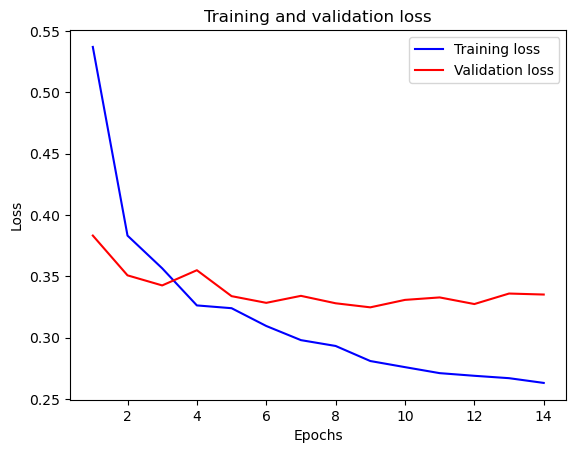

In [922]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


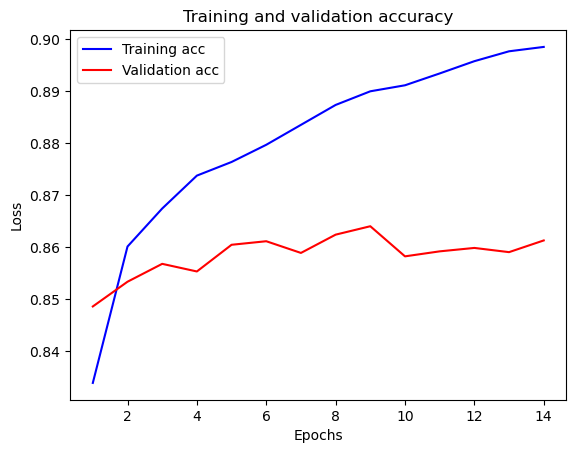

In [923]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [924]:
model_3_text_drop_new.save('../models/model_3_text_drop.h5')

In [925]:
model_3_text_drop_new.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_82 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 user_embedding_LUT (Embedding)  (None, 1, 100)      433600      ['user_id[0][0]']                
                                                                                           